In [22]:
import import_ipynb
import preprocess_model

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam

In [24]:
# Load the data from the CSV file
df = pd.read_csv('./data/new_data_asia.csv')

In [25]:
numerical_features = ['School enrollment, primary', 'School enrollment, tertiary', 'Primary completion rate', 'Year']
categorical_features = ['Country']
target = 'Literacy rate'

# Drop rows with missing target values
df.dropna(subset=[target], inplace=True)

In [26]:
# X_train, X_temp, y_train, y_temp = train_test_split(df[numerical_features + categorical_features], df[target], test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# # Standardize the numerical features
# scaler = StandardScaler()
# X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
# X_val[numerical_features] = scaler.transform(X_val[numerical_features])
# X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# # Preprocess categorical features
# label_encoders = {}
# for cat_feature in categorical_features:
#     le = LabelEncoder()
#     X_train[cat_feature] = le.fit_transform(X_train[cat_feature])
#     X_val[cat_feature] = le.transform(X_val[cat_feature])
#     X_test[cat_feature] = le.transform(X_test[cat_feature])
#     label_encoders[cat_feature] = le

# # Train a Linear Regression model
# linear_reg_model = LinearRegression()
# linear_reg_model.fit(X_train, y_train)

# # Make predictions on the validation set
# predictions_val = linear_reg_model.predict(X_val)

# # Evaluate the model on the validation set
# val_mse = mean_squared_error(y_val, predictions_val)
# print(f'Validation Mean Squared Error: {val_mse}')

# # Plot actual vs. predicted values on the validation set
# plt.scatter(y_val, predictions_val)
# plt.xlabel('Actual Literacy rate (Validation)')
# plt.ylabel('Predicted Literacy rate (Validation)')
# plt.title('Actual vs. Predicted Literacy rate (Linear Regression - Validation)')
# plt.show()

# # Now, you can use the trained Linear Regression model for predictions on the test set.
# # Make predictions on the test set
# predictions_test = linear_reg_model.predict(X_test)

# # Evaluate the model on the test set
# test_mse = mean_squared_error(y_test, predictions_test)
# print(f'Test Mean Squared Error: {test_mse}')

# # Plot actual vs. predicted values on the test set
# plt.scatter(y_test, predictions_test)
# plt.xlabel('Actual Literacy rate (Test)')
# plt.ylabel('Predicted Literacy rate (Test)')
# plt.title('Actual vs. Predicted Literacy rate (Linear Regression - Test)')
# plt.show()

In [27]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(df[numerical_features + categorical_features], df[target], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Shapes after splitting:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Shapes after splitting:
X_train: (160, 5) y_train: (160,)
X_val: (53, 5) y_val: (53,)
X_test: (54, 5) y_test: (54,)


In [28]:

# Standardize the numerical features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])


In [29]:

# Preprocess categorical features
label_encoders = {}
for cat_feature in categorical_features:
    le = LabelEncoder()
    X_train[cat_feature] = le.fit_transform(X_train[cat_feature])
    X_val[cat_feature] = le.transform(X_val[cat_feature])
    X_test[cat_feature] = le.transform(X_test[cat_feature])
    label_encoders[cat_feature] = le


In [30]:

# Define the learning rate
learning_rate = 0.0001  


Epoch 1/200
3/3 [==============================] - 5s 246ms/step - loss: 8871.6846 - val_loss: 8870.8740
Epoch 2/200
3/3 [==============================] - 0s 46ms/step - loss: 8819.4707 - val_loss: 8807.6748
Epoch 3/200
3/3 [==============================] - 0s 46ms/step - loss: 8741.8721 - val_loss: 8718.1543
Epoch 4/200
3/3 [==============================] - 0s 60ms/step - loss: 8637.3984 - val_loss: 8591.5664
Epoch 5/200
3/3 [==============================] - 0s 49ms/step - loss: 8483.7988 - val_loss: 8413.1211
Epoch 6/200
3/3 [==============================] - 0s 57ms/step - loss: 8270.8301 - val_loss: 8162.4297
Epoch 7/200
3/3 [==============================] - 0s 42ms/step - loss: 7996.4429 - val_loss: 7812.3726
Epoch 8/200
3/3 [==============================] - 0s 52ms/step - loss: 7603.6172 - val_loss: 7336.0928
Epoch 9/200
3/3 [==============================] - 0s 51ms/step - loss: 7032.2158 - val_loss: 6698.4551
Epoch 10/200
3/3 [==============================] - 0s 57ms/ste

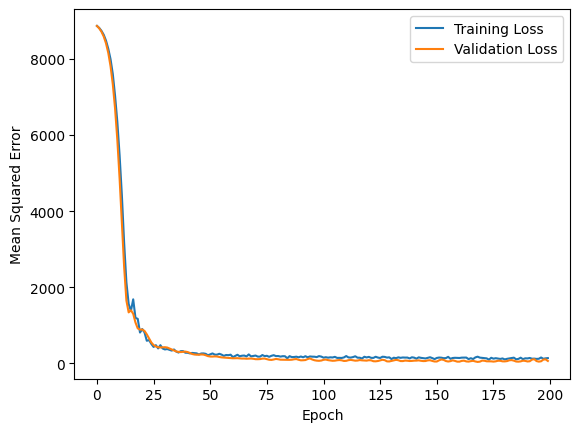

In [31]:

# Define the model
input_layers = []
embedding_layers = []

for cat_feature in categorical_features:
    input_layer = Input(shape=(1,), name=cat_feature)
    embedding_layer = Embedding(input_dim=len(df[cat_feature].unique()), output_dim=10)(input_layer)
    flatten_layer = Flatten()(embedding_layer)
    input_layers.append(input_layer)
    embedding_layers.append(flatten_layer)

numerical_input = Input(shape=(len(numerical_features),), name='numerical_input')
embedding_layers.append(numerical_input)

# Concatenate all input layers
concatenated = Concatenate()(embedding_layers)

# Fully connected layers with dropout for regularization
x = Dense(256, activation='relu')(concatenated)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1, activation='linear', name='output')(x)

# Model
model = Model(inputs=input_layers + [numerical_input], outputs=output_layer)

# Compile the model with Mean Squared Error loss and the specified learning rate
model.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error') #soft-max reg

# Train the model for more epochs
history = model.fit([X_train[cat_feature] for cat_feature in categorical_features] + [X_train[numerical_features]],
                    y_train, epochs=200, batch_size=64,
                    validation_data=([X_val[cat_feature] for cat_feature in categorical_features] + [X_val[numerical_features]], y_val),
                    verbose=1)

# Evaluate the model on the test set
test_loss = model.evaluate([X_test[cat_feature] for cat_feature in categorical_features] + [X_test[numerical_features]], y_test)
print(f'Test Loss: {test_loss}')

# Plot the training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [32]:
# Make predictions
test = ['School enrollment, primary', 'School enrollment, tertiary', 'Primary completion rate', 'Year', 'Country']
print(df[test])
new_data = pd.DataFrame({
    'School enrollment, primary': [100.911263,100.911262512207],
    'School enrollment, tertiary': [28.845509  ,28.8455085754395],
    'Primary completion rate': [96.636715, 96.63671493530276],
    'Year': [2023,2023],
    'Country': ["Afghanistan", "Japan"],
    # other columns as needed
})
# 100.911262512207,28.8455085754395,96.63671493530276
# Preprocess the new data similar to the training data
# Standardize numerical features
new_data[numerical_features] = scaler.transform(new_data[numerical_features])

# Preprocess categorical features
for cat_feature in categorical_features:
    new_data[cat_feature] = label_encoders[cat_feature].transform(new_data[cat_feature])

# # Make predictions on the new data
predictions_future = model.predict([new_data[cat_feature] for cat_feature in categorical_features] + [new_data[numerical_features]])
print(predictions_future)

# predictions = model.predict([X_test[cat_feature] for cat_feature in categorical_features] + [X_test[numerical_features]])
# print(y_test)
# print(predictions)
# import seaborn as sns

# sns.kdeplot(y_test, label='Actual', shade=True)
# sns.kdeplot(predictions.flatten(), label='Predicted', shade=True)
# plt.xlabel('Literacy rate')
# plt.title('Distribution of Actual vs. Predicted Literacy rate')
# plt.show()
# residuals = y_test - predictions.flatten()

# # plt.scatter(y_test, residuals)
# # plt.axhline(y=0, color='red', linestyle='--')
# # plt.xlabel('Actual Literacy rate')
# # plt.ylabel('Residuals')
# # plt.title('Residual Plot')
# # plt.show()

# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# mse = mean_squared_error(y_test, predictions)
# mae = mean_absolute_error(y_test, predictions)

# r2 = r2_score(y_test, predictions)
# print(f'Mean Squared Error: {mse}')
# print(f'Mean Absolute Error: {mae}')
# print(f'R-squared: {r2}')


      School enrollment, primary  School enrollment, tertiary   
1                     100.911263                    28.845509  \
7                     106.182419                    28.845509   
11                    100.290298                     3.755610   
30                     96.620567                    53.306129   
33                    101.619812                    53.590759   
...                          ...                          ...   
1263                  117.423347                    28.506929   
1273                   97.419968                    21.506201   
1282                  112.737328                     9.135250   
1283                  114.000847                    10.333910   
1306                   80.937019                     8.826330   

      Primary completion rate  Year      Country  
1                   96.636715  2021  Afghanistan  
7                   96.636715  2015  Afghanistan  
11                  96.636715  2011  Afghanistan  
30             

ValueError: y contains previously unseen labels: 'Japan'